# Analysis of sequential DNA-MERFISH for CTP07

by Pu Zheng

2022.05.30

analysis for dataset:

\\10.245.74.158\Chromatin_NAS_7\20220528-CTP07chr2_hSTG


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

15208


# 0. fov parameters

In [2]:
reload(ia)
reload(classes)
reload(classes.batch_functions)
reload(classes.field_of_view)
reload(io_tools.load)
reload(get_img_info)
reload(visual_tools)
reload(ia.correction_tools)
reload(ia.correction_tools.alignment)
reload(ia.spot_tools.matching)
reload(ia.segmentation_tools.chromosome)
reload(ia.spot_tools.fitting)

fov_param = {'data_folder':r'\\10.245.74.158\Chromatin_NAS_7\20220530-CTP07chr2_hSTG_from0308_250gene',
             'save_folder':r'D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525',
             'experiment_type': 'DNA',
             'num_threads': 16,
             'correction_folder':r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50',
             'shared_parameters':{
                     'single_im_size':[50,2048,2048],
                     'distance_zxy': [250, 108, 108],
                     'corr_channels':['750','647','561'],
                     'num_empty_frames': 0, 
                     'num_buffer_frames':0,
                     'corr_hot_pixel':True,
                     'corr_Z_shift':False,
                     'corr_bleed':True,
                     'min_num_seeds':5,
                     'max_num_seeds': 20000,
                     'spot_seeding_th': 1000,
                     'normalize_intensity_local':False,
                     'normalize_intensity_background':False,
                     'corr_gaussian_highpass':False,
                 }, 
             }

# 1. Load FOV

## 1.1 define required floders

In [3]:
save_folder = fov_param['save_folder']

save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = True

print(f"{len(save_filenames)} fovs detected")

mosaic_folder = os.path.join(save_folder, 'Mosaic')
if not os.path.exists(mosaic_folder):
    os.makedirs(mosaic_folder)
    print(f"Creating mosaic_folder: {mosaic_folder}")
else:
    print(f"Use mosaic_folder: {mosaic_folder}")


88 fovs detected
Creating mosaic_folder: D:\Pu_Temp\20220530-CTP08chr2_hSTG_from0525\Mosaic


In [21]:
pixel_sizes = np.array(fov_param['shared_parameters']['distance_zxy'])
single_im_size = np.array(fov_param['shared_parameters']['single_im_size'])
intensity_th = np.array(fov_param['shared_parameters']['spot_seeding_th'])

## 1.2 load positions

In [4]:
folders, fovs = ia.io_tools.data.get_folders(fov_param['data_folder'])

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 16
- Number of field of views: 88


In [34]:
from ImageAnalysis3.segmentation_tools import cell
reload(cell)

<module 'ImageAnalysis3.segmentation_tools.cell' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\segmentation_tools\\cell.py'>

In [32]:
# transpose with microscope
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
dna_microscope_params = Align_Segmentation._read_microscope_json(dna_microscope_file)
dna_microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [35]:
from tqdm import tqdm

dna_global_positions = []
ref_folder = folders[0]
fovID_2_DAPI = {}
fovID_2_GlobalPosition = {}
for _save_filename in tqdm(save_filenames):
    _fov_name = os.path.basename(_save_filename).replace('.hdf5', '.dax')
    _fov_id = fovs.index(_fov_name)
    # load DAPI
    with h5py.File(_save_filename, 'r') as _f:
        _dna_dapi_max = _f.attrs['dapi_im'].max(0)
        fovID_2_DAPI[_fov_id] = ia.segmentation_tools.cell.Align_Segmentation._correct_image2D_by_microscope_param(
            _dna_dapi_max, dna_microscope_params)
    fovID_2_GlobalPosition[_fov_id] = ia.classes.preprocess.DaxProcesser._FindGlobalPosition(os.path.join(ref_folder, _fov_name))
    #print(fovID_2_GlobalPosition, fovID_2_DAPI)


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [02:55<00:00,  2.00s/it]


In [94]:
ref_fov_centers_micron = np.loadtxt(r'\\10.245.74.158\Chromatin_NAS_7\20220530-CTP07chr2_hSTG_from0308_250gene\Alignment\adjusted_translated_positions_all.txt', delimiter=',')

In [95]:
ref_fov_centers_micron.shape

(88, 2)

In [96]:
fovID_2_GlobalPosition[0]

array([ -823.95, -1470.3 ])

In [97]:
ref_fov_centers_micron[0]

array([ -823.17, -1467.48])

In [146]:
sel_fov = 2
fov_centers_micron = np.array(list(fovID_2_GlobalPosition.values()))[:sel_fov] #
#fov_centers_micron = ref_fov_centers_micron[:sel_fov]
#fov_centers_micron = np.fliplr(fov_centers_micron)
# determine image boundaries
#pixel_in_micron = pixel_sizes[-1]/1000
pixel_in_micron = 0.106
layer_size = single_im_size[-2:]
# detect boundaries
lower_lims = np.min(fov_centers_micron - np.array(layer_size)/2 * pixel_in_micron, axis=0)
upper_lims = np.max(fov_centers_micron + np.array(layer_size)/2 * pixel_in_micron, axis=0)

# calculate pixels in each dimension
mosiac_size = np.ceil((upper_lims - lower_lims)/pixel_in_micron).astype(np.int32)

mosiac = np.zeros(mosiac_size, dtype=np.uint16)
print(lower_lims, upper_lims)
for _ifov, _dapi in fovID_2_DAPI.items():
    
    if _ifov >= sel_fov:
        break
    #_center_micron = fovID_2_GlobalPosition[_ifov] #fov_centers_micron[_ifov]#
    _center_micron = fov_centers_micron[_ifov]#
    _center_pixel = np.ceil((_center_micron - lower_lims)/pixel_in_micron).astype(np.int32)
    
    _lpxl, _upxl = (_center_pixel - np.array(layer_size)/2).astype(np.int32), (_center_pixel + np.array(layer_size)/2).astype(np.int32)
    mosiac[np.arange(_lpxl[0], _upxl[0]), np.arange(_lpxl[1], _upxl[1])[:, np.newaxis]] += _dapi
    print(_ifov, _center_pixel, _lpxl, _upxl)

[ -932.494 -1578.844] [ -713.056 -1158.556]
0 [1024 1025] [0 1] [2048 2049]
1 [1047 2941] [  23 1917] [2071 3965]


<IPython.core.display.Javascript object>


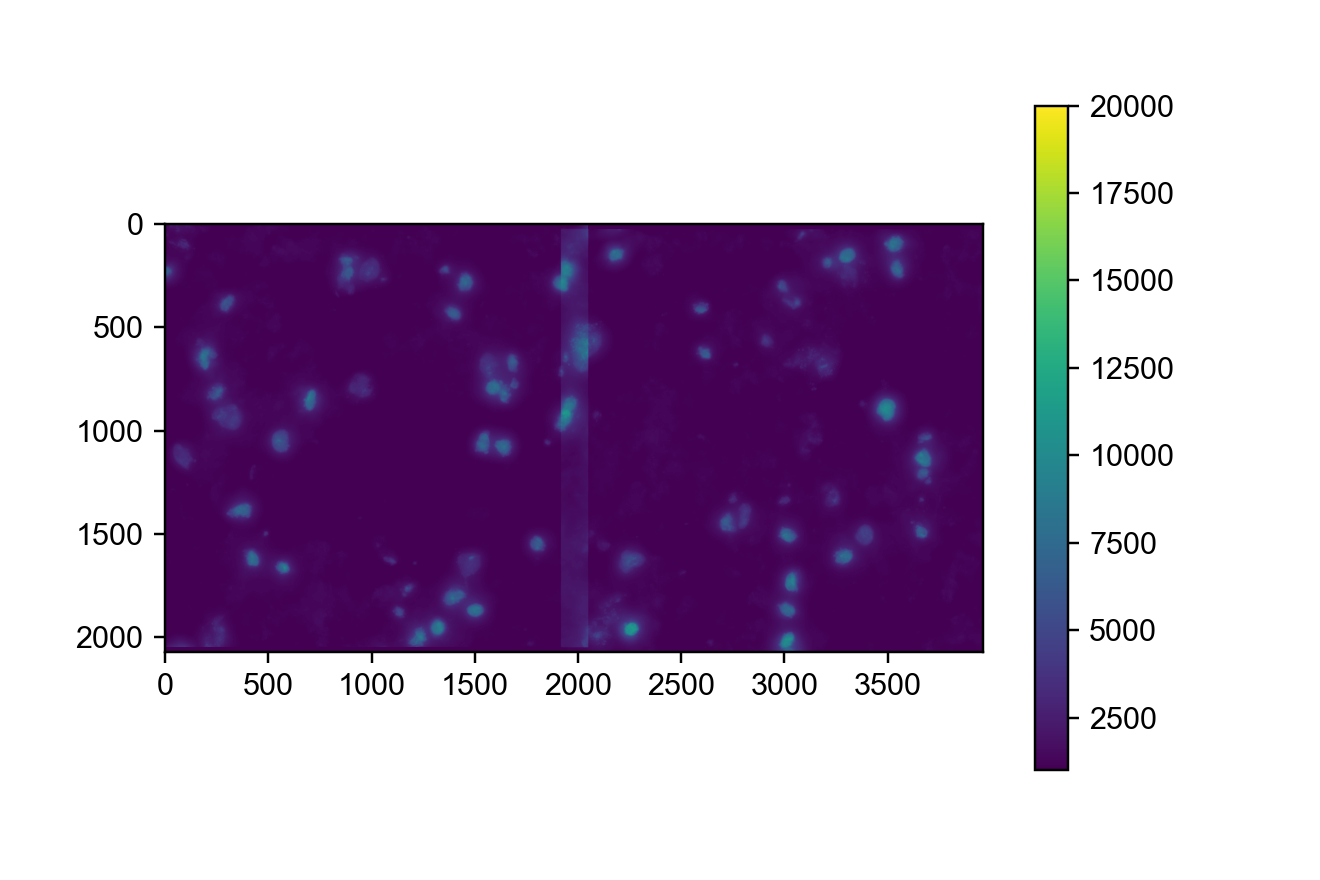

In [147]:
%matplotlib notebook
plt.figure(dpi=100)
plt.imshow(mosiac, vmin=1000, vmax=20000)
plt.colorbar()
plt.show()

In [136]:
fovID_2_GlobalPosition[0], fovID_2_GlobalPosition[1]

(array([ -823.95, -1470.3 ]), array([ -821.6, -1267.1]))

In [151]:
from skimage.registration import phase_cross_correlation

<IPython.core.display.Javascript object>


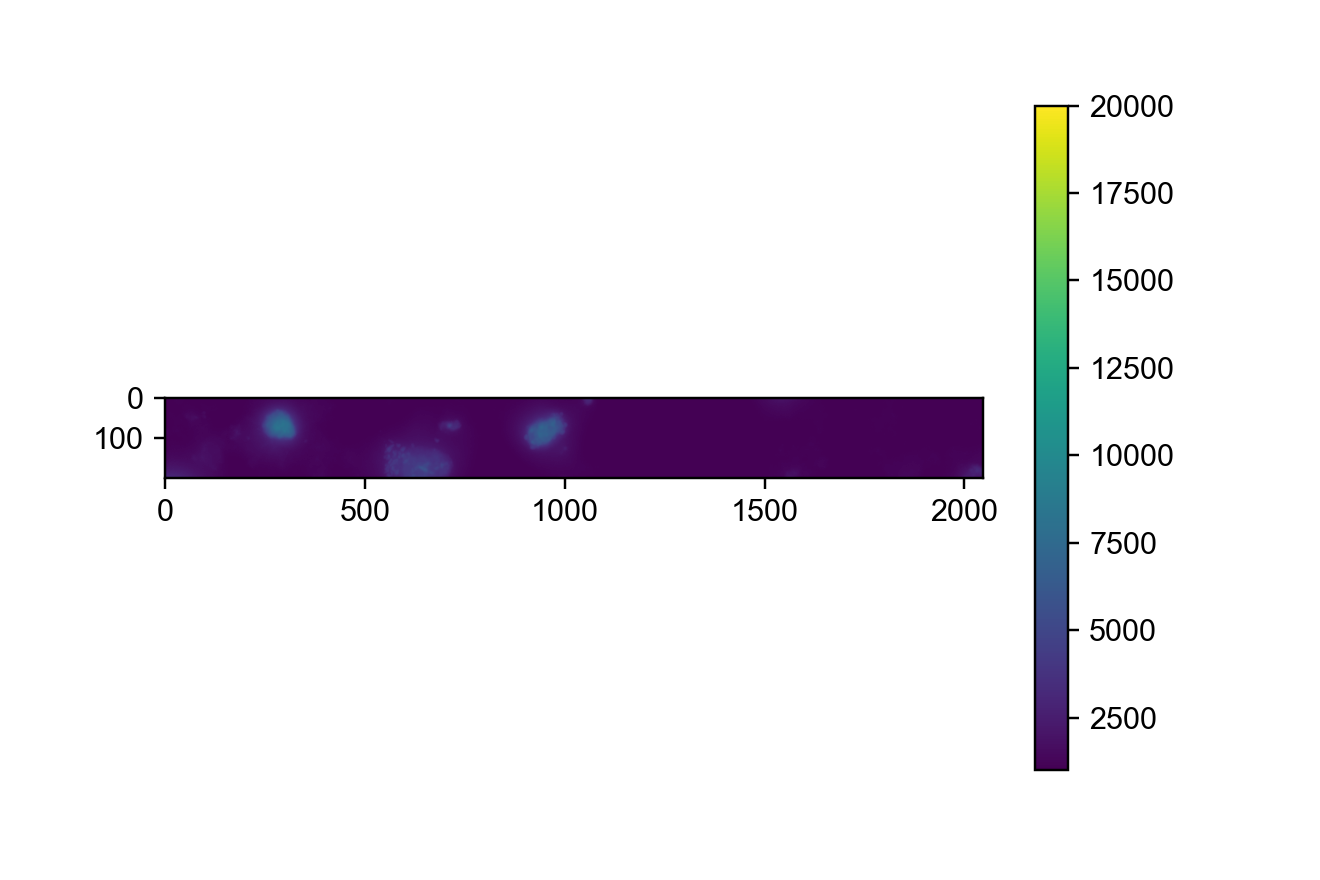

In [153]:
%matplotlib notebook
plt.figure(dpi=100)
plt.imshow(fovID_2_DAPI[0][-200:,:], vmin=1000, vmax=20000)
plt.colorbar()
plt.show()


In [156]:
_dft, _, _ = phase_cross_correlation(fovID_2_DAPI[1][:200,:], fovID_2_DAPI[0][-200:,:])

In [157]:
_dft * pixel_in_micron

array([-4.24 , -9.752])

<IPython.core.display.Javascript object>


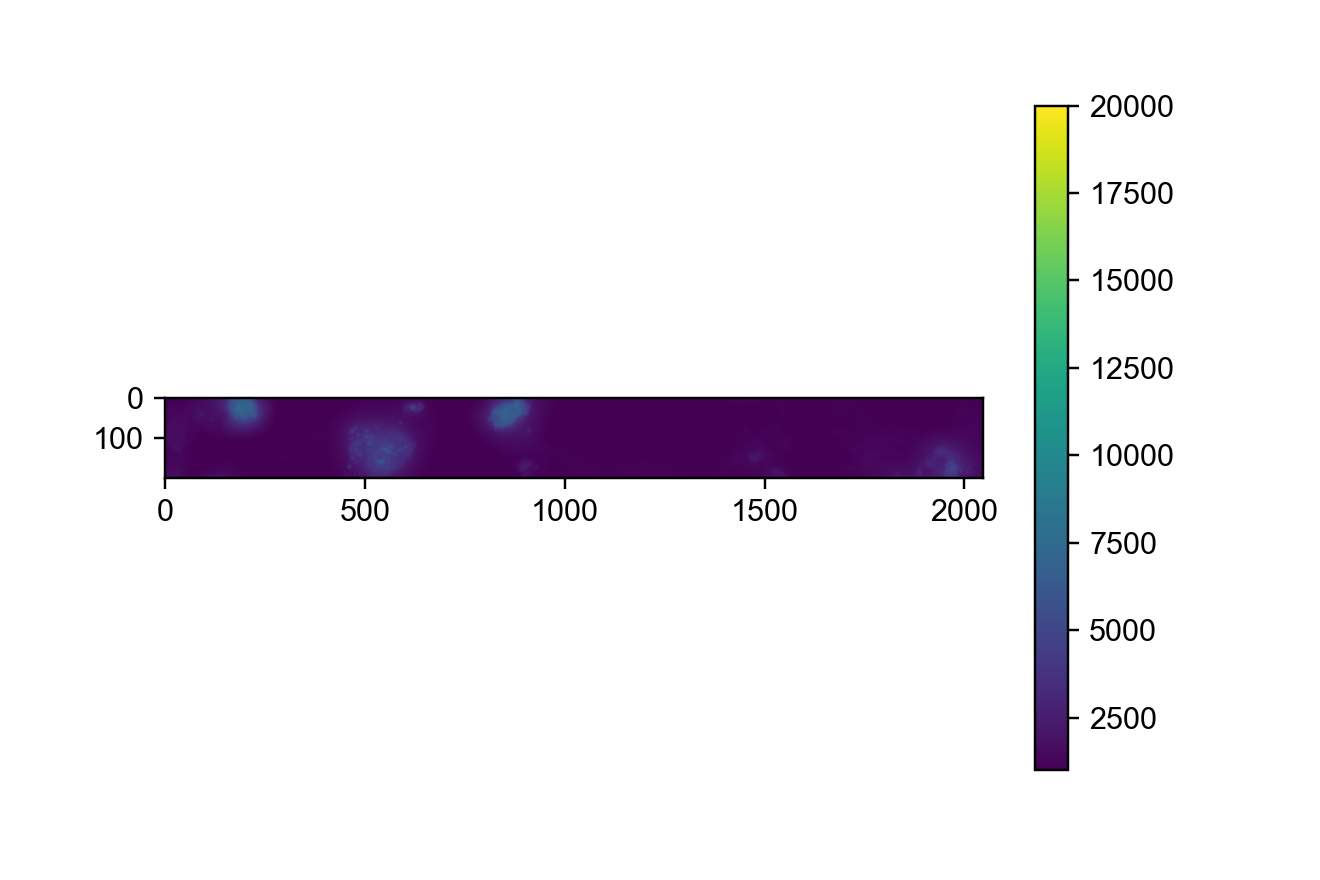

In [154]:
plt.figure(dpi=100)
plt.imshow(fovID_2_DAPI[1][:200,:], vmin=1000, vmax=20000)
plt.colorbar()
plt.show()

In [118]:
ref_fov_centers_micron[9], ref_fov_centers_micron[2]

(array([ -422.04, -1269.76]), array([ -622.03, -1268.62]))

In [116]:
fovID_2_GlobalPosition[9], fovID_2_GlobalPosition[2]

(array([ -421.3 , -1269.35]), array([ -622. , -1268.8]))